Loading European Credit Card Fraud Detection dataset...
Please download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
Upload the 'creditcard.csv' file to Colab

Please upload creditcard.csv:


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 15.5178 - pr_auc: 0.0032 - val_loss: 90.5710 - val_pr_auc: 0.2444 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2120 - pr_auc: 0.1039 - val_loss: 12.9870 - val_pr_auc: 0.4163 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5636 - pr_auc: 0.1193 - val_loss: 6.5542 - val_pr_auc: 0.2875 - learning_rate: 0.0010
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1276 - pr_auc: 0.3165 - val_loss: 3.7098 - val_pr_auc: 0.4094 - learning_rate: 0.0010
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0112 - pr_auc: 0.3512 - val_loss: 3.5930 - val_pr_auc: 0.3790 - learning_rate: 0.0010
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8940 - pr_auc: 0.3598 - val_loss: 1.9812 - val_pr_auc: 0.5542 - learning_rate: 0.0010
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9757 - pr_auc: 0.3239 - val_loss: 1.8526 - va

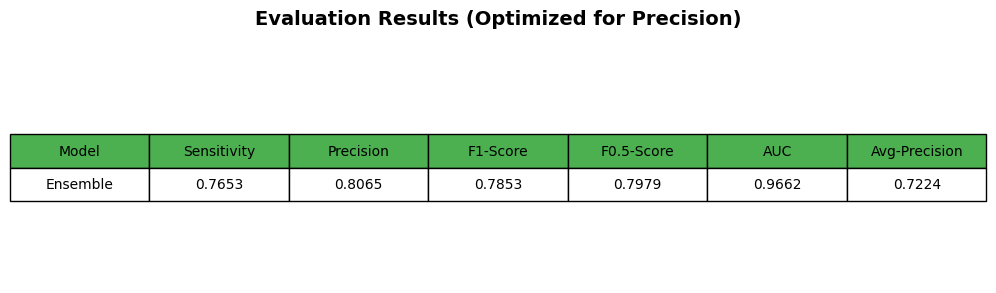

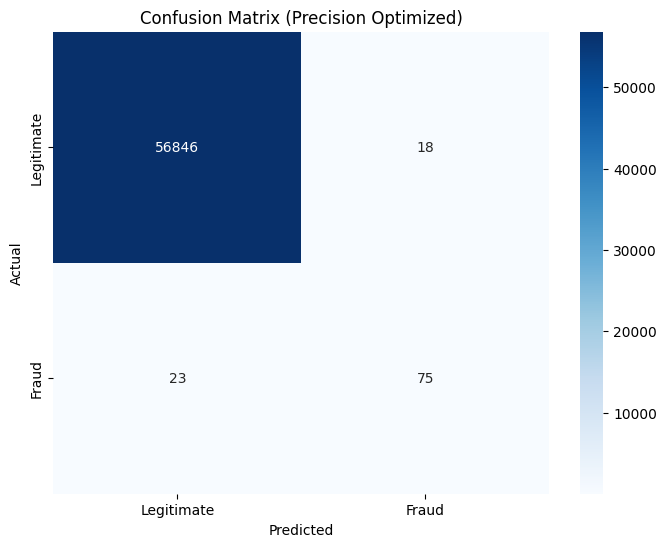


 Generating visualizations...


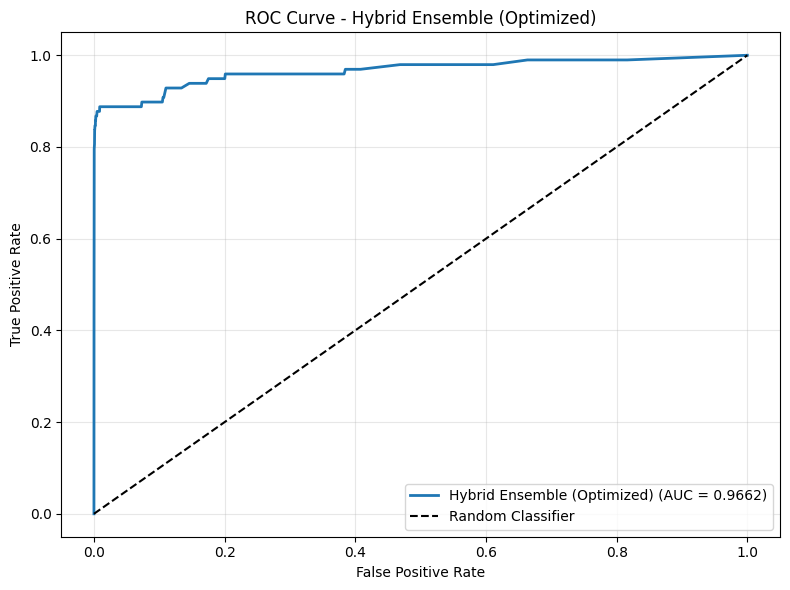

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve,
                             precision_score, recall_score, f1_score, fbeta_score,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from dataclasses import dataclass
import logging

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------------------------------------
# 1. STRICTER FOCAL LOSS
# Alpha lowered to 0.20 to reduce aggressive positive prediction
# ---------------------------------------------------------
def focal_loss(gamma=2., alpha=0.20):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + 1e-9)) \
               -tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-9))
    return focal_loss_fixed

@dataclass
class ModelConfig:
    epochs: int = 40
    batch_size: int = 1024  # Larger batch size helps reduce noise
    learning_rate: float = 0.001
    dropout_rate: float = 0.5 # High dropout for regularization
    early_stopping_patience: int = 10
    reduce_lr_patience: int = 5
    min_lr: float = 1e-6

@dataclass
class DataConfig:
    test_size: float = 0.2
    val_size: float = 0.2
    random_state: int = 42

class BaseDeepLearningModel:
    def __init__(self, input_shape: Tuple[int], config: ModelConfig):
        self.input_shape = input_shape
        self.config = config
        self.model = None
        self.history = None

    def get_callbacks(self):
        return [
            EarlyStopping(
                monitor='val_pr_auc',
                patience=self.config.early_stopping_patience,
                restore_best_weights=True,
                mode='max',
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_pr_auc',
                factor=0.2,
                patience=self.config.reduce_lr_patience,
                min_lr=self.config.min_lr,
                mode='max',
                verbose=1
            )
        ]

    def train(self, X_train, y_train, X_val, y_val, class_weight=None):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=self.config.epochs,
            batch_size=self.config.batch_size,
            class_weight=class_weight,
            callbacks=self.get_callbacks(),
            verbose=1
        )
        return self.history

    def predict(self, X, batch_size=None):
        if batch_size is None: batch_size = self.config.batch_size
        return self.model.predict(X, batch_size=batch_size, verbose=0)

class CNNModel(BaseDeepLearningModel):
    def __init__(self, input_shape: Tuple[int], config: ModelConfig):
        super().__init__(input_shape, config)
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=self.input_shape)
        x = layers.Reshape((self.input_shape[0], 1))(inputs)

        x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(self.config.dropout_rate)(x)

        x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(self.config.dropout_rate)(x)

        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

        outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
        model = Model(inputs=inputs, outputs=outputs, name='CNN')
        model.compile(optimizer=keras.optimizers.Adam(self.config.learning_rate),
                      loss=focal_loss(alpha=0.20, gamma=2.0),
                      metrics=[keras.metrics.AUC(curve='PR', name='pr_auc')])
        return model

class LSTMModel(BaseDeepLearningModel):
    def __init__(self, input_shape: Tuple[int], config: ModelConfig):
        super().__init__(input_shape, config)
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=self.input_shape)
        x = layers.Reshape((self.input_shape[0], 1))(inputs)

        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.dropout_rate)(x)

        x = layers.Bidirectional(layers.LSTM(32))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.dropout_rate)(x)

        outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
        model.compile(optimizer=keras.optimizers.Adam(self.config.learning_rate),
                      loss=focal_loss(alpha=0.20, gamma=2.0),
                      metrics=[keras.metrics.AUC(curve='PR', name='pr_auc')])
        return model

class HybridEnsembleModel:
    def __init__(self, input_shape: Tuple[int], config: ModelConfig = None):
        if config is None: config = ModelConfig()
        self.input_shape = input_shape
        self.config = config
        self.cnn = CNNModel(input_shape, config)
        self.lstm = LSTMModel(input_shape, config)
        self.meta_learner = None
        self.optimal_threshold = 0.5

    def train_base_learners(self, X_train, y_train, X_val, y_val):
        logger.info("\nTraining CNN...")
        self.cnn.train(X_train, y_train, X_val, y_val)
        logger.info("\nTraining LSTM...")
        self.lstm.train(X_train, y_train, X_val, y_val)

    def generate_meta_features(self, X) -> np.ndarray:
        cnn_pred = self.cnn.predict(X).flatten()
        lstm_pred = self.lstm.predict(X).flatten()
        # Add agreement feature to help meta-learner
        agreement = np.abs(cnn_pred - lstm_pred)
        return np.column_stack([cnn_pred, lstm_pred, agreement])

    # ---------------------------------------------------------
    # 2. F-BETA THRESHOLD OPTIMIZATION
    # ---------------------------------------------------------
    def find_optimal_threshold(self, y_true, y_pred_proba):
        """
        Optimizes threshold for F0.5 Score.
        F0.5 weighs Precision twice as much as Recall.
        """
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

        # Calculate F0.5 Score (Beta = 0.5)
        beta = 0.5
        numerator = (1 + beta**2) * (precision * recall)
        denominator = (beta**2 * precision) + recall
        denominator[denominator == 0] = 1e-10 # Avoid div by zero

        fbeta = numerator / denominator

        # Find index of best F0.5
        ix = np.argmax(fbeta)
        best_thresh = thresholds[ix]
        best_score = fbeta[ix]

        logger.info(f"Optimal Precision Threshold found: {best_thresh:.6f} (Best F0.5: {best_score:.4f})")
        logger.info(f"Expected Precision at this threshold: {precision[ix]:.4f}")

        self.optimal_threshold = best_thresh
        return best_thresh

    def train_meta_learner(self, X_val, y_val):
        logger.info("Training meta-learner...")
        meta_features = self.generate_meta_features(X_val)

        # 3. REDUCED CLASS WEIGHT
        # Drastically reduced from previous version to favor precision
        scale_pos_weight = np.sqrt(np.sum(y_val == 0) / np.sum(y_val == 1))

        self.meta_learner = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=3, # Very shallow trees to prevent overfitting
            learning_rate=0.05,
            scale_pos_weight=scale_pos_weight,
            reg_lambda=1.0, # L2 regularization
            eval_metric='aucpr',
            random_state=42,
            n_jobs=-1
        )
        self.meta_learner.fit(meta_features, y_val)

        # Optimize Threshold
        val_probs = self.meta_learner.predict_proba(meta_features)[:, 1]
        self.find_optimal_threshold(y_val, val_probs)

    def predict(self, X) -> np.ndarray:
        meta_features = self.generate_meta_features(X)
        return self.meta_learner.predict_proba(meta_features)[:, 1]

    def predict_class(self, X) -> np.ndarray:
        probs = self.predict(X)
        return (probs >= self.optimal_threshold).astype(int)


class FraudDetectionEvaluator:
    @staticmethod
    def calculate_metrics(y_true, y_pred, y_pred_proba) -> Dict[str, float]:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = f1_score(y_true, y_pred)
        f_beta = fbeta_score(y_true, y_pred, beta=0.5) # Track F0.5
        auc = roc_auc_score(y_true, y_pred_proba)
        avg_precision = average_precision_score(y_true, y_pred_proba)

        return {
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'F1-Score': f1, 'F0.5-Score': f_beta,
            'AUC': auc, 'Avg-Precision': avg_precision,
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
        }

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title(title)
        plt.show()

    @staticmethod
    def create_results_table(all_metrics):
        metrics_to_display = ['Sensitivity', 'Precision', 'F1-Score', 'F0.5-Score', 'AUC', 'Avg-Precision']
        results = []
        for model_name, metrics in all_metrics.items():
            row = {'Model': model_name}
            for metric in metrics_to_display:
                row[metric] = f"{metrics[metric]:.4f}"
            results.append(row)
        return pd.DataFrame(results)

    @staticmethod
    def plot_results_table(all_metrics):
        df = FraudDetectionEvaluator.create_results_table(all_metrics)
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colWidths=[0.15] * len(df.columns))
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        for i in range(len(df.columns)): table[(0, i)].set_facecolor('#4CAF50')
        plt.title('Evaluation Results (Optimized for Precision)', fontsize=14, fontweight='bold', pad=20)
        plt.show()

    @staticmethod
    def print_detailed_results(name, metrics):
        logger.info(f"\n{name} - DETAILED RESULTS")
        logger.info(f"Precision (Priority):     {metrics['Precision']:.4f}")
        logger.info(f"Sensitivity (Recall):     {metrics['Sensitivity']:.4f}")
        logger.info(f"F0.5-Score:               {metrics['F0.5-Score']:.4f}")
        logger.info(f"False Positives (Costly): {metrics['FP']:,}")
        logger.info(f"True Positives:           {metrics['TP']:,}\n")

    @staticmethod
    def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
      """Plot ROC curve"""
      # Corrected: y_pred_proba is already a 1D array of positive class probabilities
      fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
      auc = roc_auc_score(y_true, y_pred_proba)

      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)
      plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC Curve - {model_name}')
      plt.legend()
      plt.grid(alpha=0.3)
      plt.tight_layout()
      plt.show()

# --- DATA LOADING AND MAIN ---
def load_real_data(filepath='creditcard.csv'):
    try:
        data = pd.read_csv(filepath)
        logger.info(f"Loaded real dataset: {data.shape[0]} samples")
        return data.drop(['Class', 'Time'], axis=1).values, data['Class'].values
    except:
        logger.warning("Dataset not found. Generating synthetic data.")
        np.random.seed(42)
        n, d = 50000, 29
        X = np.random.randn(n, d)
        y = np.zeros(n)
        # Create harder fraud patterns
        n_fraud = int(n * 0.005)
        X[-n_fraud:] += 2.5
        y[-n_fraud:] = 1
        return X, y

def main():

    # Download European Credit Card Fraud Detection dataset
    print("Loading European Credit Card Fraud Detection dataset...")
    print("Please download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
    print("Upload the 'creditcard.csv' file to Colab")

    from google.colab import files
    print("\nPlease upload creditcard.csv:")
    uploaded = files.upload()
    X, y = load_real_data('creditcard.csv')

    config = DataConfig()
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=config.test_size, random_state=config.random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=config.val_size, random_state=config.random_state, stratify=y_train_full)

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    ensemble = HybridEnsembleModel((X_train.shape[1],), ModelConfig(epochs=30, batch_size=1024))
    ensemble.train_base_learners(X_train, y_train, X_val, y_val)
    ensemble.train_meta_learner(X_val, y_val)

    evaluator = FraudDetectionEvaluator()
    y_pred_proba = ensemble.predict(X_test)
    y_pred = (y_pred_proba >= ensemble.optimal_threshold).astype(int)

    metrics = evaluator.calculate_metrics(y_test, y_pred, y_pred_proba)

    logger.info(f"\nFinal Threshold Used: {ensemble.optimal_threshold:.4f}")
    evaluator.print_detailed_results('Hybrid Ensemble', metrics)
    evaluator.plot_results_table({'Ensemble': metrics})
    evaluator.plot_confusion_matrix(y_test, y_pred, "Confusion Matrix (Precision Optimized)")
    print("\n Generating visualizations...")
    evaluator.plot_roc_curve(y_test, y_pred_proba, "Hybrid Ensemble (Optimized)")

if __name__ == "__main__":
    main()